In [1]:

import matplotlib.pyplot as plt
import scanpy as sc
import numpy as np
import time


In [2]:
import decoupler as dc
import pandas as pd
import sys
import pickle
import tqdm
import scipy

import pydeseq2
from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats
inference = DefaultInference(n_cpus=8)
import anndata


In [3]:
dedir = '/home/ec2-user/curation/heart_datasets/deseq/'

# Convenience functions

In [4]:
neuron_cts = ['Glia','glia','neuron','Neuron','neural','Neural','Schwann']
def build_consensus_ad(ads,filter_by = 'cell_type'):
    consensus_genes = set(ads[list(ads.keys())[0]].var_names)
    for i,dataset in enumerate(ads.keys()):
        consensus_genes = consensus_genes&set(ads[dataset].var_names)
        
    ads_filt = {}
    for i,dataset in enumerate(ads.keys()):
        ads_filt[dataset] = ads[dataset][:,list(consensus_genes)].copy()
        ads_filt[dataset].obs['dataset'] = dataset
    
        if 'age' in ads_filt[dataset].obs.columns:
            pass
        elif 'Age_bin' in ads_filt[dataset].obs.columns:
            x1 = ads_filt[dataset].obs['Age_bin'].str.split('-').str[1].astype(float)
            x2 = ads_filt[dataset].obs['Age_bin'].str.split('-').str[0].astype(float)
            x = (x1+x2)/2
            ads_filt[dataset].obs['age'] = x
    ad=anndata.concat([ads_filt[x] for x in ads_filt.keys()])
    if filter_by=='cell_type':
        ad=ad[ad.obs['cell_type'].str.contains( "|".join(neuron_cts),regex=True)].copy()
        ad.obs['donor_id'] = ad.obs['donor_id']+'_'+ad.obs['dataset']
        ad = dc.get_pseudobulk(ad,sample_col='donor_id',groups_col=None,
            mode='sum',
            min_cells=0,
            min_counts=0,use_raw=False)
        #the "cell counts" obtained thus are not meaningful, but the counts are.
    return ad

# 1. Differential expression between male and female pseudoglia

In [5]:
with open('/home/ec2-user/curation/heart_datasets/gg_250821_heart_celltype_psbulks.p', 'rb') as fp:
    ads = pickle.load(fp)

In [6]:
ads.keys()

dict_keys(['amrute', 'brener', 'chaffin', 'eraslan', 'hill', 'kanemaru', 'knight_schrijver', 'kuppe', 'linna_kuosmanen', 'litvinukova', 'reichart', 'selewa', 'sim', 'simonson', 'tucker'])

In [7]:
ad=build_consensus_ad(ads,filter_by = 'cell_type')

/home/ec2-user/miniconda/lib/python3.9/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/ec2-user/miniconda/lib/python3.9/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [8]:
ad.obs

,donor_id,sex,age,dataset,psbulk_n_cells,psbulk_counts
10_144396-RV_brener,10_144396-RV_brener,male,71,brener,1.0,5453.0
10_144421-RV_brener,10_144421-RV_brener,male,63,brener,1.0,279997.0
11_144422-RV_brener,11_144422-RV_brener,male,68,brener,1.0,170338.0
1221_tucker,1221_tucker,female,52,tucker,1.0,40295.0
13_144471-RV_brener,13_144471-RV_brener,male,65,brener,1.0,140987.0
...,...,...,...,...,...,...
UK1_hill,UK1_hill,female,9.0,hill,1.0,129444.0
UK2_hill,UK2_hill,female,3.0,hill,1.0,44852.0
donor_2207_selewa,donor_2207_selewa,male,54.0,selewa,1.0,636356.0
donor_2336_selewa,donor_2336_selewa,male,47.0,selewa,1.0,1049303.0


In [9]:
dds = DeseqDataSet(
    adata=ad.copy(),
    design_factors=['sex','dataset'],
    refit_cooks=True,
    inference=inference,
    quiet=True)
dds.deseq2()


/home/ec2-user/miniconda/lib/python3.9/site-packages/pydeseq2/dds.py:262: UserWarning: Some factor levels in the design contain underscores ('_').
                    They will be converted to hyphens ('-').
  self.obsm["design_matrix"] = build_design_matrix(
Fitting dispersions...
... done in 0.06 seconds.

Fitting MAP dispersions...
... done in 0.05 seconds.

Fitting LFCs...
... done in 0.19 seconds.



In [10]:
stat_res_Y_vs_X = DeseqStats(dds, contrast=["sex", "female", "male"], inference=inference,quiet=True)

In [11]:
stat_res_Y_vs_X.summary()

Log2 fold change & Wald test p-value: sex female vs male
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       2.532260       -0.031317  0.186808 -0.167643  0.866864  0.999769
A1BG-AS1   1.646271        0.021806  0.148487  0.146857  0.883245  0.999769
A2M       19.691748       -0.306818  0.121447 -2.526359  0.011525  0.432530
A2M-AS1    0.658086       -0.069336  0.258704 -0.268015  0.788688       NaN
A2ML1      0.635794        0.386558  0.287651  1.343844  0.178999       NaN
...             ...             ...       ...       ...       ...       ...
ZXDC      11.697651        0.095999  0.059280  1.619422  0.105356  0.841597
ZYG11A     0.225146       -0.069713  0.472444 -0.147557  0.882692       NaN
ZYG11B    10.970708        0.068783  0.073251  0.939009  0.347726  0.948458
ZYX        2.644326        0.065928  0.191391  0.344466  0.730496  0.992735
ZZEF1     11.803907        0.032587  0.070588  0.461659  0.644326  0.992735

[15333 rows x 6 columns]


In [12]:
res = stat_res_Y_vs_X.results_df
df_ensembl = pd.read_csv('/home/ec2-user/platform/anno/gene_details_ensembl_v104.txt',sep='\t').set_index('ensembl_id')
dict_ensembl = dict(df_ensembl[['gene_symbol', 'chromosome_name']].values)
res['chr'] = res.index.map(dict_ensembl)

In [13]:
res.to_csv(dedir+'gg_250821_f_vs_m_sd.csv')

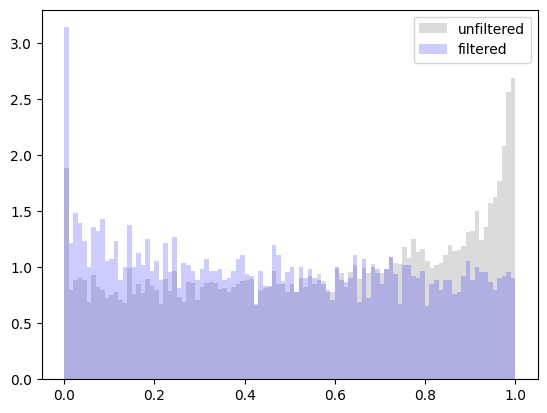

In [14]:
plt.hist(res.loc[:,'pvalue'],100,facecolor='lightgray',alpha=0.8,density=True,label='unfiltered')
plt.hist(res.loc[res['baseMean']>5,'pvalue'],100,facecolor='b',density=True,alpha=0.2,label='filtered')
plt.legend()
plt.show()

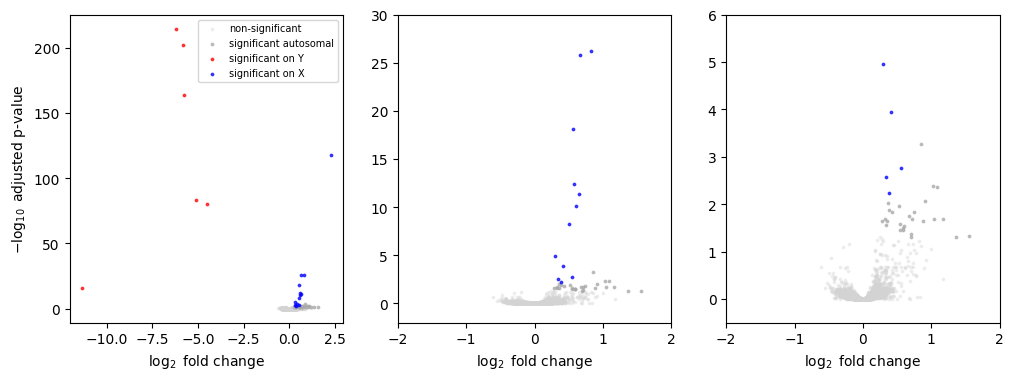

In [15]:
fig1,ax1=plt.subplots(1,3,figsize=(12,4))
gf_ = res['baseMean']>5
sig_ = (res['padj']<0.05)&(res['log2FoldChange'].abs()>0.25)
for i in range(3):
    gf = gf_&(~res['chr'].isin(['X','Y'])) & ~sig_
    ax1[i].scatter(res.loc[gf,'log2FoldChange'],-np.log10(res.loc[gf,'padj']),3,'lightgray',alpha=0.3,label='non-significant')
    gf = gf_&(~res['chr'].isin(['X','Y'])) & sig_
    ax1[i].scatter(res.loc[gf,'log2FoldChange'],-np.log10(res.loc[gf,'padj']),3,'darkgray',alpha=0.7,label='significant autosomal')
    gf = gf_&(res['chr'].isin(['Y'])) & sig_
    ax1[i].scatter(res.loc[gf,'log2FoldChange'],-np.log10(res.loc[gf,'padj']),3,'r',alpha=0.7,label='significant on Y')
    gf = gf_&(res['chr'].isin(['X'])) & sig_
    ax1[i].scatter(res.loc[gf,'log2FoldChange'],-np.log10(res.loc[gf,'padj']),3,'b',alpha=0.7,label='significant on X')
    # ax1[i].set_xlabel('log2 fold change')
    ax1[i].set_xlabel(r'$\log_2$ fold change')
ax1[1].set_xlim([-2,2])
ax1[1].set_ylim([-2,30])
ax1[2].set_xlim([-2,2])
ax1[2].set_ylim([-0.5,6])
ax1[0].set_ylabel(r'$-\log_{10}$ adjusted p-value')
ax1[0].legend(loc='upper right',fontsize=7)

In [16]:
res[sig_&gf_].sort_values('padj')

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,chr
TTTY14,20.567314,-6.188292,0.195742,-31.614478,2.335255e-219,2.608247e-215,Y
UTY,18.879845,-5.799014,0.189103,-30.665847,1.624901e-206,9.074261e-203,Y
USP9Y,12.665324,-5.737521,0.207717,-27.621877,6.077152e-168,2.262524e-164,Y
XIST,74.771622,2.264528,0.096410,23.488430,5.355353e-122,1.495349e-118,X
LINC00278,6.538859,-5.127477,0.258398,-19.843324,1.258560e-87,2.811372e-84,Y
TTTY10,6.038820,-4.492524,0.231240,-19.427999,4.474717e-84,7.139730e-81,Y
NLGN4X,80.125900,0.816796,0.071917,11.357472,6.808678e-30,6.337177e-27,X
KDM6A,19.624311,0.655842,0.058215,11.265910,1.933450e-29,1.661131e-26,X
JPX,36.498276,0.554379,0.057856,9.582022,9.516290e-22,7.085829e-19,X
RPS4Y1,14.705578,-11.335968,1.264935,-8.961702,3.197046e-19,2.231738e-16,Y


In [17]:
res[sig_&gf_&(res['chr']=='X')].sort_values('padj')

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,chr
XIST,74.771622,2.264528,0.096410,23.488430,5.355353e-122,1.495349e-118,X
NLGN4X,80.125900,0.816796,0.071917,11.357472,6.808678e-30,6.337177e-27,X
KDM6A,19.624311,0.655842,0.058215,11.265910,1.933450e-29,1.661131e-26,X
JPX,36.498276,0.554379,0.057856,9.582022,9.516290e-22,7.085829e-19,X
ZFX,9.986452,0.577930,0.071400,8.094250,5.761841e-16,3.785529e-13,X
AP1S2,49.829556,0.654168,0.084138,7.774950,7.547737e-15,4.683371e-12,X
CA5B,6.367006,0.603549,0.081341,7.420011,1.171105e-13,6.884246e-11,X
OFD1,10.041802,0.508858,0.074664,6.815325,9.405088e-12,5.002163e-09,X
USP9X,18.936020,0.297069,0.053280,5.575651,2.466062e-08,1.101738e-05,X
EIF2S3,13.353533,0.412948,0.080239,5.146471,2.654325e-07,1.140237e-04,X


# 2. The effects of age on expression of XIST in male pseudoglia

In [18]:
with open('/home/ec2-user/curation/heart_datasets/gg_250821_heart_celltype_psbulks.p', 'rb') as fp:
    ads = pickle.load(fp)

In [19]:
ad=build_consensus_ad(ads,filter_by = 'cell_type')

/home/ec2-user/miniconda/lib/python3.9/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/ec2-user/miniconda/lib/python3.9/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [20]:
ad = ad[(ad.obs['sex']=='male')&(ad.obs['age']>0)&(ad.obs['age']<100)]

In [21]:
ad.obs['age'] = ad.obs['age'].astype('float')
ad.obs['logage'] = np.log(ad.obs['age'])

/tmp/ipykernel_4384/838056906.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  ad.obs['age'] = ad.obs['age'].astype('float')


In [22]:
dds = DeseqDataSet(
    adata=ad.copy(),
    design_factors=['age','dataset'],
    continuous_factors = ['age'],
    refit_cooks=True,
    inference=inference,
    quiet=True)
dds.deseq2()
stat_res_Y_vs_X = DeseqStats(dds, contrast=["age", "", ""], inference=inference,quiet=True)
stat_res_Y_vs_X.summary()
res = stat_res_Y_vs_X.results_df
df_ensembl = pd.read_csv('/home/ec2-user/platform/anno/gene_details_ensembl_v104.txt',sep='\t').set_index('ensembl_id')
dict_ensembl = dict(df_ensembl[['gene_symbol', 'chromosome_name']].values)
res['chr'] = res.index.map(dict_ensembl)
res.to_csv(dedir+'gg_250821_age_ad.csv')

/home/ec2-user/miniconda/lib/python3.9/site-packages/pydeseq2/dds.py:262: UserWarning: Some factor levels in the design contain underscores ('_').
                    They will be converted to hyphens ('-').
  self.obsm["design_matrix"] = build_design_matrix(
/home/ec2-user/miniconda/lib/python3.9/site-packages/pydeseq2/utils.py:549: RuntimeWarning: overflow encountered in exp
  mu_ = np.maximum(size_factors * np.exp(X @ beta), min_mu)
/home/ec2-user/miniconda/lib/python3.9/site-packages/pydeseq2/utils.py:404: RuntimeWarning: invalid value encountered in multiply
  - counts * np.log(mu)
/home/ec2-user/miniconda/lib/python3.9/site-packages/pydeseq2/utils.py:402: RuntimeWarning: invalid value encountered in subtract
  -logbinom
/home/ec2-user/miniconda/lib/python3.9/site-packages/pydeseq2/utils.py:553: RuntimeWarning: overflow encountered in exp
  mu_ = np.maximum(size_factors * np.exp(X @ beta), min_mu)
/home/ec2-user/miniconda/lib/python3.9/site-packages/pydeseq2/utils.py:556: RuntimeW

Log2 fold change & Wald test p-value: age
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       2.162466        0.006461  0.008221  0.785837  0.431963  0.823362
A1BG-AS1   1.493764        0.003768  0.006846  0.550365  0.582069       NaN
A2M       20.823246        0.012378  0.004511  2.744294  0.006064  0.323378
A2M-AS1    0.556064        0.012699  0.012213  1.039804  0.298431       NaN
A2ML1      0.608667        0.008329  0.014283  0.583146  0.559795       NaN
...             ...             ...       ...       ...       ...       ...
ZXDC      10.677865        0.001314  0.002576  0.509956  0.610082  0.901390
ZYG11A     0.233632        0.015941  0.022344  0.713415  0.475589       NaN
ZYG11B     8.996626        0.006418  0.003035  2.114274  0.034492  0.489777
ZYX        1.448278        0.006180  0.009069  0.681455  0.495584       NaN
ZZEF1     11.118493       -0.000341  0.003168 -0.107493  0.914398  0.986505

[15333 rows x 6 columns]


In [23]:
res_=pd.read_csv(dedir+'gg_250821_age_ad.csv',index_col=0)


In [24]:
res_.sort_values('pvalue')[:10]

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,chr
RASGEF1B,16.700485,0.039788,0.006436,6.181747,6.339618e-10,0.000005,4
LRRC7,12.256691,-0.037172,0.007183,-5.175417,2.274026e-07,0.000898,1
PTCHD4,4.699916,0.038002,0.007843,4.845456,1.263212e-06,0.003324,6
CLU,26.654140,0.028358,0.006446,4.399364,1.085688e-05,0.021426,8
COQ5,2.377383,0.027685,0.006382,4.338220,1.436415e-05,0.022678,12
ZNF727,1.838566,0.032900,0.007774,4.232286,2.313276e-05,0.025192,7
JUND,13.090012,0.022234,0.005266,4.222167,2.419642e-05,0.025192,19
ZNF444,2.236050,0.021327,0.005066,4.210057,2.553066e-05,0.025192,19
PLCG2,11.574961,0.035258,0.008472,4.161780,3.157762e-05,0.027697,16
RAPGEF5,19.463799,0.014020,0.003411,4.109844,3.959269e-05,0.031254,7


In [25]:
dds = DeseqDataSet(
    adata=ad.copy(),
    design_factors=['logage','dataset'],
    continuous_factors = ['logage'],
    refit_cooks=True,
    inference=inference,
    quiet=True)
dds.deseq2()
stat_res_Y_vs_X = DeseqStats(dds, contrast=["logage", "", ""], inference=inference,quiet=True)
stat_res_Y_vs_X.summary()
res = stat_res_Y_vs_X.results_df
df_ensembl = pd.read_csv('/home/ec2-user/platform/anno/gene_details_ensembl_v104.txt',sep='\t').set_index('ensembl_id')
dict_ensembl = dict(df_ensembl[['gene_symbol', 'chromosome_name']].values)
res['chr'] = res.index.map(dict_ensembl)
res.to_csv(dedir+'gg_250821_age_logad.csv')

/home/ec2-user/miniconda/lib/python3.9/site-packages/pydeseq2/dds.py:262: UserWarning: Some factor levels in the design contain underscores ('_').
                    They will be converted to hyphens ('-').
  self.obsm["design_matrix"] = build_design_matrix(
Fitting dispersions...
... done in 1.81 seconds.

Fitting MAP dispersions...
... done in 2.03 seconds.

Fitting LFCs...
... done in 2.56 seconds.



Log2 fold change & Wald test p-value: logage
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       2.162466       -0.012774  0.268200 -0.047629  0.962012       NaN
A1BG-AS1   1.493764        0.025284  0.214640  0.117796  0.906230       NaN
A2M       20.823246        0.279226  0.151640  1.841368  0.065568  0.588148
A2M-AS1    0.556064        0.218618  0.417357  0.523815  0.600407       NaN
A2ML1      0.608667       -0.173657  0.459988 -0.377525  0.705784       NaN
...             ...             ...       ...       ...       ...       ...
ZXDC      10.677865        0.023019  0.080765  0.285016  0.775632  0.962078
ZYG11A     0.233632        0.203771  0.763754  0.266802  0.789622       NaN
ZYG11B     8.996626        0.281458  0.102810  2.737636  0.006188  0.260804
ZYX        1.448278        0.149135  0.327889  0.454834  0.649229       NaN
ZZEF1     11.118493        0.047236  0.103478  0.456484  0.648042  0.935703

[15333 rows x 6 columns]


In [26]:
res_.loc[['XIST']]

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,chr
XIST,28.874529,0.006502,0.003324,1.956411,0.050417,0.523487,X


In [27]:
res.loc[['XIST']]

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,chr
XIST,28.874529,0.276818,0.109568,2.526438,0.011523,0.344877,X


In [28]:
res[(res['baseMean']>10)&(res['padj']<0.05)].sort_values('padj')

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,chr
PPARG,10.691004,0.890291,0.187446,4.749597,0.000002,0.005927,3
FSTL3,16.318647,0.710975,0.156293,4.548994,0.000005,0.007837,19
ABLIM3,12.133965,0.562540,0.129164,4.355223,0.000013,0.010098,5
RAPGEF5,19.463799,0.525523,0.120933,4.345586,0.000014,0.010098,7
RASGEF1B,16.700485,0.952284,0.218345,4.361380,0.000013,0.010098,4
LRRC7,12.256691,-0.984752,0.231207,-4.259183,0.000021,0.013259,1
CADPS2,10.831530,0.714960,0.169745,4.211971,0.000025,0.014723,7
MECOM,24.624016,0.863235,0.209829,4.113995,0.000039,0.015559,3
ZFPM2,35.044270,0.584390,0.142300,4.106738,0.000040,0.015559,8
GSN,81.598297,0.536157,0.133455,4.017520,0.000059,0.020121,9


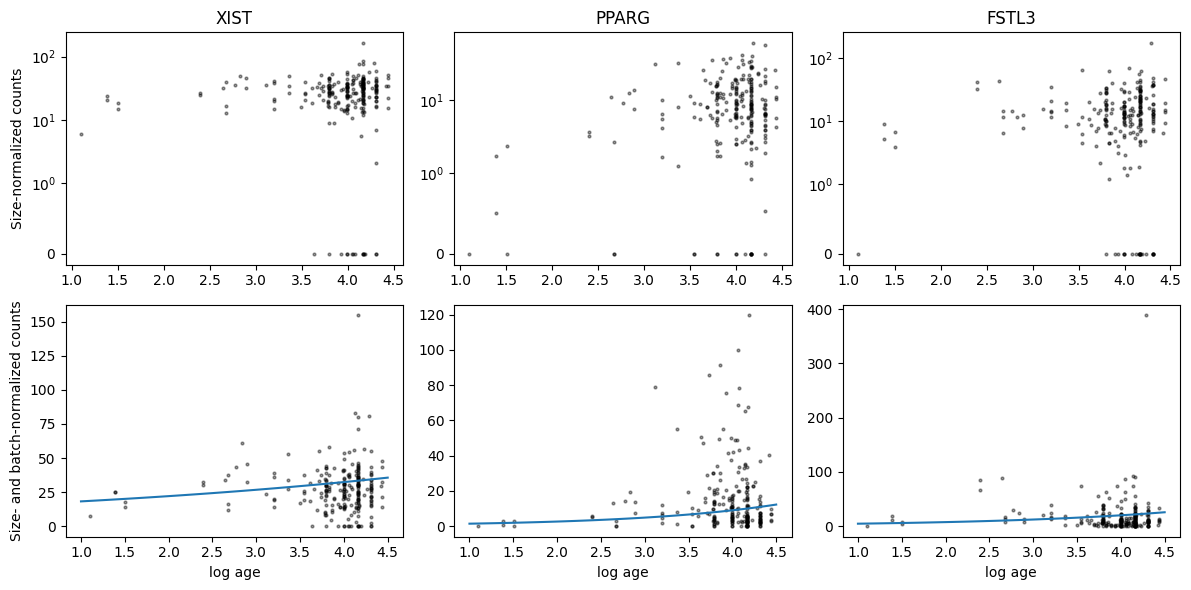

In [29]:
genes= ['XIST','PPARG','FSTL3']
fig1,ax1= plt.subplots(2,len(genes),figsize=(12,6))
for i,gene in enumerate(genes):
    y = dds[:,gene].layers['normed_counts'].squeeze()
    y_ = y*np.exp((dds.obsm['design_matrix'].iloc[:,1:-1]) @ (dds[:,gene].varm['LFC'].iloc[:,1:-1].T)).values.squeeze()
    ax1[0,i].scatter(dds.obs['logage'].astype('float'),y,4,'k',alpha=0.4)    
    ax1[0,i].set_yscale('symlog',linthresh=1)
    ax1[1,i].scatter(dds.obs['logage'].astype('float'),y_,4,'k',alpha=0.4)    
    xl = np.linspace(1,4.5)
    yl = np.exp(dds[:,gene].varm['LFC'].intercept[0] + dds[:,gene].varm['LFC'].logage[0]*xl)
    ax1[1,i].plot(xl,yl)
    # ax1[1,i].set_yscale('symlog',linthresh=1)
    ax1[1,i].set_xlabel('log age')
    ax1[0,i].set_title(gene)
ax1[0,0].set_ylabel('Size-normalized counts')
ax1[1,0].set_ylabel('Size- and batch-normalized counts')
fig1.tight_layout()

In [30]:
res.query('baseMean>10 & padj<0.05').sort_values('padj')[:10]

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,chr
PPARG,10.691004,0.890291,0.187446,4.749597,0.000002,0.005927,3
FSTL3,16.318647,0.710975,0.156293,4.548994,0.000005,0.007837,19
ABLIM3,12.133965,0.562540,0.129164,4.355223,0.000013,0.010098,5
RAPGEF5,19.463799,0.525523,0.120933,4.345586,0.000014,0.010098,7
RASGEF1B,16.700485,0.952284,0.218345,4.361380,0.000013,0.010098,4
LRRC7,12.256691,-0.984752,0.231207,-4.259183,0.000021,0.013259,1
CADPS2,10.831530,0.714960,0.169745,4.211971,0.000025,0.014723,7
MECOM,24.624016,0.863235,0.209829,4.113995,0.000039,0.015559,3
ZFPM2,35.044270,0.584390,0.142300,4.106738,0.000040,0.015559,8
GSN,81.598297,0.536157,0.133455,4.017520,0.000059,0.020121,9


In [31]:
# g_ = dds.var_names[np.where((dds.layers['normed_counts']>1e3).any(0))]
res_.query('baseMean>10 & padj<0.05').sort_values('padj')[:10]

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,chr
RASGEF1B,16.700485,0.039788,0.006436,6.181747,6.339618e-10,0.000005,4
LRRC7,12.256691,-0.037172,0.007183,-5.175417,2.274026e-07,0.000898,1
CLU,26.654140,0.028358,0.006446,4.399364,1.085688e-05,0.021426,8
JUND,13.090012,0.022234,0.005266,4.222167,2.419642e-05,0.025192,19
PLCG2,11.574961,0.035258,0.008472,4.161780,3.157762e-05,0.027697,16
RAPGEF5,19.463799,0.014020,0.003411,4.109844,3.959269e-05,0.031254,7
UBC,26.090155,0.022804,0.005645,4.039663,5.352798e-05,0.038414,12
GPX3,42.730286,0.029883,0.007514,3.977083,6.976573e-05,0.045894,5


In [32]:
dds[:,gene].varm['LFC'].columns

Index(['intercept', 'dataset_brener_vs_amrute', 'dataset_chaffin_vs_amrute',
       'dataset_eraslan_vs_amrute', 'dataset_hill_vs_amrute',
       'dataset_kanemaru_vs_amrute', 'dataset_kuppe_vs_amrute',
       'dataset_linna-kuosmanen_vs_amrute', 'dataset_litvinukova_vs_amrute',
       'dataset_reichart_vs_amrute', 'dataset_selewa_vs_amrute',
       'dataset_sim_vs_amrute', 'dataset_simonson_vs_amrute',
       'dataset_tucker_vs_amrute', 'logage'],
      dtype='object')

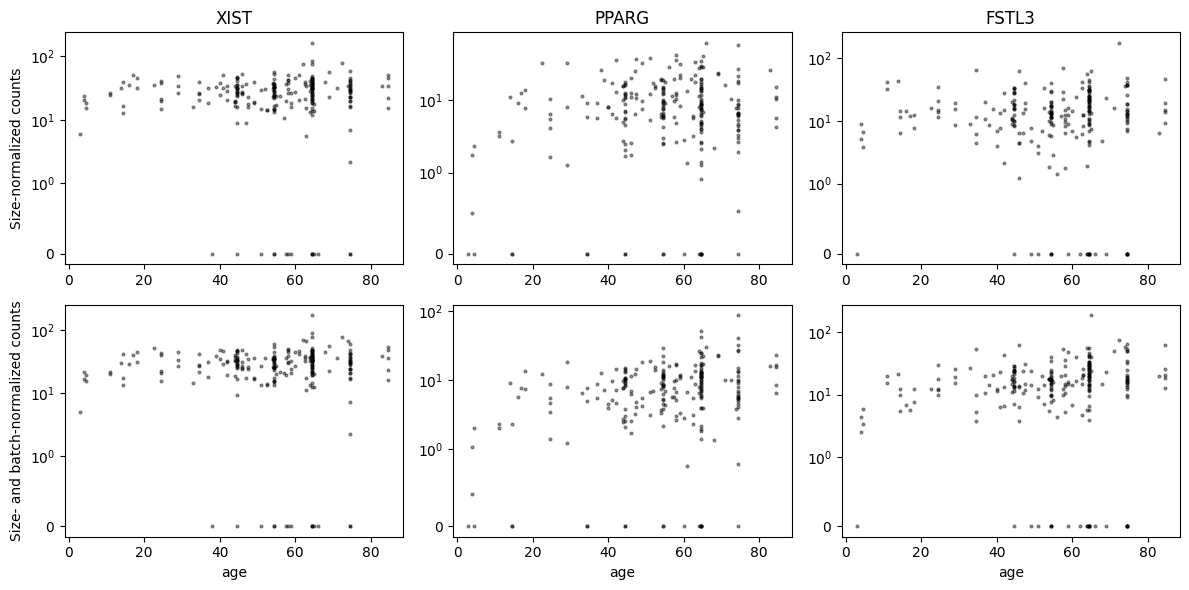

In [33]:
genes= ['XIST','PPARG','FSTL3']
fig1,ax1= plt.subplots(2,len(genes),figsize=(12,6))
for i,gene in enumerate(genes):
    y = dds[:,gene].layers['normed_counts'].squeeze()
    y_ = y/np.exp((dds.obsm['design_matrix'].iloc[:,1:-1]) @ (dds[:,gene].varm['LFC'].iloc[:,1:-1].T)).values.squeeze()
    ax1[0,i].scatter(dds.obs['age'].astype('float'),y,4,'k',alpha=0.4)    
    ax1[0,i].set_yscale('symlog',linthresh=1)
    ax1[1,i].scatter(dds.obs['age'].astype('float'),y_,4,'k',alpha=0.4)    
    ax1[1,i].set_yscale('symlog',linthresh=1)
    ax1[1,i].set_xlabel('age')
    ax1[0,i].set_title(gene)
ax1[0,0].set_ylabel('Size-normalized counts')
ax1[1,0].set_ylabel('Size- and batch-normalized counts')
fig1.tight_layout()

# 3. The effects of pathology on expression of XIST

In [34]:
with open('/home/ec2-user/curation/heart_datasets/gg_250821_heart_celltype_psbulks.p', 'rb') as fp:
    ads = pickle.load(fp)

## Chaffin

In [35]:
ads['chaffin'].obs['disease'].value_counts()

disease
NF     301
HCM    293
DCM    210
Name: count, dtype: int64

In [36]:
ad=build_consensus_ad({'chaffin':ads['chaffin']},filter_by = 'cell_type')

In [37]:
ad = ad[(ad.obs['sex']=='male')]

In [38]:
ad.obs['disease'].value_counts()

disease
HCM    10
DCM     7
NF      6
Name: count, dtype: int64

In [39]:
df_ensembl = pd.read_csv('/home/ec2-user/platform/anno/gene_details_ensembl_v104.txt',sep='\t').set_index('ensembl_id')
dict_ensembl = dict(df_ensembl[['gene_symbol', 'chromosome_name']].values)


dds = DeseqDataSet(
    adata=ad.copy(),
    design_factors=['disease'],
    refit_cooks=True,
    inference=inference,
    quiet=True)
dds.deseq2()

stat_res_Y_vs_X = DeseqStats(dds, contrast=["disease", "DCM", "NF"], inference=inference,quiet=True)
stat_res_Y_vs_X.summary()
res = stat_res_Y_vs_X.results_df
res['chr'] = res.index.map(dict_ensembl)
res.to_csv(dedir+'gg_250821_chaffin_dcm_p.csv')


Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.01 seconds.



Log2 fold change & Wald test p-value: disease DCM vs NF
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.799020       -0.508708  1.266316 -0.401723  0.687888       NaN
A1BG-AS1   1.037270       -0.375253  0.600585 -0.624813  0.532094       NaN
A1CF       0.372787        0.984147  4.196495  0.234516  0.814584       NaN
A2M       13.512217        0.305935  0.361463  0.846382  0.397340  0.812726
A2M-AS1    0.176153        0.939648  2.499813  0.375887  0.707001       NaN
...             ...             ...       ...       ...       ...       ...
ZXDC      10.974718       -0.272262  0.237561 -1.146073  0.251765  0.703912
ZYG11A     0.107316        1.158693  3.778012  0.306694  0.759076       NaN
ZYG11B     6.759818        0.011140  0.341734  0.032599  0.973994  0.994741
ZYX        1.329771       -0.583338  1.139388 -0.511975  0.608669       NaN
ZZEF1     11.269037       -0.012520  0.341620 -0.036648  0.970765  0.994039

[26264 rows x 6 columns]


In [40]:
res_dcm = res.copy()

In [41]:


stat_res_Y_vs_X = DeseqStats(dds, contrast=["disease", "HCM", "NF"], inference=inference,quiet=True)
stat_res_Y_vs_X.summary()
res = stat_res_Y_vs_X.results_df
res['chr'] = res.index.map(dict_ensembl)
res.to_csv(dedir+'gg_250821_chaffin_hcm_p.csv')

Log2 fold change & Wald test p-value: disease HCM vs NF
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.799020       -0.938807  1.141695 -0.822292  0.410911       NaN
A1BG-AS1   1.037270       -0.686278  0.565267 -1.214078  0.224718       NaN
A1CF       0.372787       -0.855369  3.940296 -0.217082  0.828144       NaN
A2M       13.512217        0.020262  0.325357  0.062277  0.950342  0.993446
A2M-AS1    0.176153        0.857345  2.257297  0.379811  0.704086       NaN
...             ...             ...       ...       ...       ...       ...
ZXDC      10.974718        0.054608  0.203683  0.268103  0.788620  0.958031
ZYG11A     0.107316        0.291845  3.484693  0.083751  0.933255       NaN
ZYG11B     6.759818        0.101797  0.302279  0.336765  0.736294  0.948105
ZYX        1.329771        0.442394  0.937292  0.471991  0.636933       NaN
ZZEF1     11.269037        0.020409  0.301418  0.067710  0.946016  0.993446

[26264 rows x 6 columns]


In [42]:
res_hcm=res.copy()

In [43]:
res_hcm.loc[['XIST']]

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,chr
XIST,30.473883,0.885505,0.27459,3.224827,0.00126,0.049965,X


In [44]:
res_dcm.loc[['XIST']]

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,chr
XIST,30.473883,0.976217,0.303637,3.215085,0.001304,0.041742,X


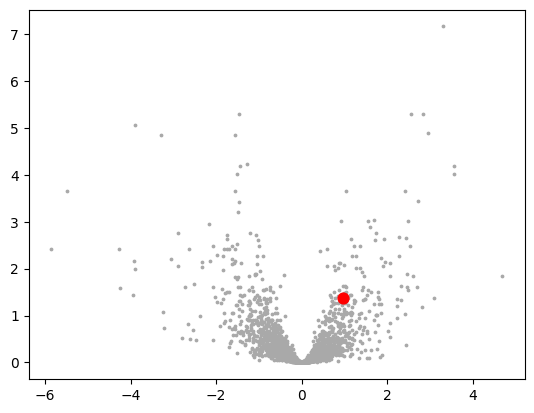

In [45]:
gf=res['baseMean']>5
plt.scatter(res_dcm.loc[gf,'log2FoldChange'],-np.log10(res_dcm.loc[gf,'padj']),3,'darkgray')
plt.scatter(res_dcm.loc["XIST",'log2FoldChange'],-np.log10(res_dcm.loc['XIST','padj']),60,'r')

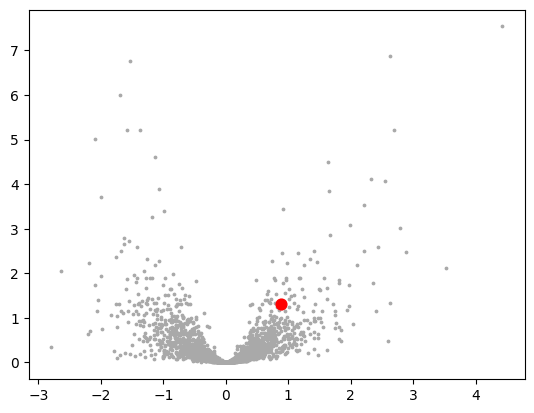

In [46]:
gf=res['baseMean']>5
plt.scatter(res_hcm.loc[gf,'log2FoldChange'],-np.log10(res_hcm.loc[gf,'padj']),3,'darkgray')
plt.scatter(res_hcm.loc["XIST",'log2FoldChange'],-np.log10(res_hcm.loc['XIST','padj']),60,'r')

In [47]:
dds = DeseqDataSet(
    adata=ad.copy(),
    design_factors=['disease','age'],
    continuous_factors = ['age'],
    refit_cooks=True,
    inference=inference,
    quiet=True)
dds.deseq2()
stat_res_Y_vs_X = DeseqStats(dds, contrast=["disease", "DCM", "NF"], inference=inference,quiet=True)
stat_res_Y_vs_X.summary()
res = stat_res_Y_vs_X.results_df
res['chr'] = res.index.map(dict_ensembl)
res.to_csv(dedir+'gg_250821_chaffin_dcm_pa.csv')
stat_res_Y_vs_X = DeseqStats(dds, contrast=["disease", "HCM", "NF"], inference=inference,quiet=True)
stat_res_Y_vs_X.summary()
res = stat_res_Y_vs_X.results_df
res['chr'] = res.index.map(dict_ensembl)
res.to_csv(dedir+'gg_250821_chaffin_hcm_pa.csv')

ad.obs['logage'] = np.log(ad.obs['age'].astype('float'))
dds = DeseqDataSet(
    adata=ad.copy(),
    design_factors=['disease','logage'],
    continuous_factors = ['logage'],
    refit_cooks=True,
    inference=inference,
    quiet=True)
dds.deseq2()
stat_res_Y_vs_X = DeseqStats(dds, contrast=["disease", "DCM", "NF"], inference=inference,quiet=True)
stat_res_Y_vs_X.summary()
res = stat_res_Y_vs_X.results_df
res['chr'] = res.index.map(dict_ensembl)
res.to_csv(dedir+'gg_250821_chaffin_dcm_ploga.csv')
stat_res_Y_vs_X = DeseqStats(dds, contrast=["disease", "HCM", "NF"], inference=inference,quiet=True)
stat_res_Y_vs_X.summary()
res = stat_res_Y_vs_X.results_df
res['chr'] = res.index.map(dict_ensembl)
res.to_csv(dedir+'gg_250821_chaffin_hcm_ploga.csv')

/home/ec2-user/miniconda/lib/python3.9/site-packages/pydeseq2/utils.py:549: RuntimeWarning: overflow encountered in exp
  mu_ = np.maximum(size_factors * np.exp(X @ beta), min_mu)
/home/ec2-user/miniconda/lib/python3.9/site-packages/pydeseq2/utils.py:404: RuntimeWarning: invalid value encountered in multiply
  - counts * np.log(mu)
/home/ec2-user/miniconda/lib/python3.9/site-packages/pydeseq2/utils.py:402: RuntimeWarning: invalid value encountered in subtract
  -logbinom
/home/ec2-user/miniconda/lib/python3.9/site-packages/pydeseq2/utils.py:553: RuntimeWarning: overflow encountered in exp
  mu_ = np.maximum(size_factors * np.exp(X @ beta), min_mu)
/home/ec2-user/miniconda/lib/python3.9/site-packages/pydeseq2/utils.py:556: RuntimeWarning: invalid value encountered in divide
  + ((1 / disp + counts) * mu_ / (1 / disp + mu_)) @ X
/home/ec2-user/miniconda/lib/python3.9/site-packages/pydeseq2/utils.py:549: RuntimeWarning: overflow encountered in exp
  mu_ = np.maximum(size_factors * np.exp(

Log2 fold change & Wald test p-value: disease DCM vs NF
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.799020       -0.545363  1.245936 -0.437714  0.661594       NaN
A1BG-AS1   1.037270       -0.404188  0.795455 -0.508122  0.611368       NaN
A1CF       0.372787        0.575633  2.495591  0.230660  0.817579       NaN
A2M       13.512217        0.332237  0.372541  0.891813  0.372493  0.775295
A2M-AS1    0.176153        0.617150  2.270761  0.271781  0.785790       NaN
...             ...             ...       ...       ...       ...       ...
ZXDC      10.974718       -0.291058  0.229529 -1.268065  0.204775  0.627601
ZYG11A     0.107316        1.083762  4.303273  0.251846  0.801160       NaN
ZYG11B     6.759818       -0.048442  0.321734 -0.150565  0.880319  0.974607
ZYX        1.329771       -0.685971  1.092124 -0.628107  0.529934       NaN
ZZEF1     11.269037       -0.037851  0.320257 -0.118190  0.905917  0.978917

[26264 rows x 6 columns]
Log2 f

/tmp/ipykernel_4384/3502586940.py:20: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  ad.obs['logage'] = np.log(ad.obs['age'].astype('float'))


Log2 fold change & Wald test p-value: disease DCM vs NF
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       0.799020       -0.545857  1.247206 -0.437664  0.661630       NaN
A1BG-AS1   1.037270       -0.409454  0.792065 -0.516945  0.605194       NaN
A1CF       0.372787        0.601249  2.555478  0.235279  0.813993       NaN
A2M       13.512217        0.324843  0.372292  0.872547  0.382910  0.786826
A2M-AS1    0.176153        0.619124  2.253826  0.274699  0.783548       NaN
...             ...             ...       ...       ...       ...       ...
ZXDC      10.974718       -0.289040  0.229229 -1.260924  0.207336  0.642019
ZYG11A     0.107316        1.072087  3.628672  0.295449  0.767651       NaN
ZYG11B     6.759818       -0.036934  0.325420 -0.113496  0.909637  0.980431
ZYX        1.329771       -0.712930  1.090195 -0.653947  0.513146       NaN
ZZEF1     11.269037       -0.036903  0.320595 -0.115107  0.908360  0.980431

[26264 rows x 6 columns]
Log2 f

## Reichart

In [48]:
ads['reichart'].obs['disease'].value_counts()

disease
dilated cardiomyopathy                             505
arrhythmogenic right ventricular cardiomyopathy     79
normal                                              58
non-compaction cardiomyopathy                       10
Name: count, dtype: int64

In [49]:
ad=build_consensus_ad({'reichart':ads['reichart']},filter_by = 'cell_type')

In [50]:
ad = ad[(ad.obs['sex']=='male')]

### ARVC

In [51]:
dds = DeseqDataSet(
    adata=ad.copy(),
    design_factors=['disease'],
    refit_cooks=True,
    inference=inference,
    quiet=True)
dds.deseq2()
stat_res_Y_vs_X = DeseqStats(dds, contrast=["disease", "arrhythmogenic right ventricular cardiomyopathy", "normal"], inference=inference,quiet=True)
stat_res_Y_vs_X.summary()
res = stat_res_Y_vs_X.results_df
df_ensembl = pd.read_csv('/home/ec2-user/platform/anno/gene_details_ensembl_v104.txt',sep='\t').set_index('ensembl_id')
dict_ensembl = dict(df_ensembl[['gene_symbol', 'chromosome_name']].values)
res['chr'] = res.index.map(dict_ensembl)
res.to_csv(dedir+'gg_250821_reichart_arvc_p.csv')


Fitting dispersions...
... done in 0.02 seconds.

Fitting MAP dispersions...
... done in 0.04 seconds.

Fitting LFCs...
... done in 0.01 seconds.



Log2 fold change & Wald test p-value: disease arrhythmogenic right ventricular cardiomyopathy vs normal
               baseMean  log2FoldChange     lfcSE      stat    pvalue  \
feature_name                                                            
A1BG           1.876563        0.592572  0.657115  0.901778  0.367175   
A1BG-AS1       2.814761       -0.348155  0.567546 -0.613439  0.539586   
A1CF           0.107973       -0.682581  3.568524 -0.191278  0.848308   
A2M           25.011181        0.842537  0.645061  1.306135  0.191507   
A2M-AS1        0.163118        0.324791  1.915053  0.169599  0.865326   
...                 ...             ...       ...       ...       ...   
ZYG11A         0.251835       -0.467826  2.161053 -0.216481  0.828613   
ZYG11B        12.701429        0.242079  0.301232  0.803631  0.421610   
ZYX            0.973537       -1.997245  0.642627 -3.107938  0.001884   
ZZEF1         14.806703       -0.498522  0.257054 -1.939365  0.052457   
ZZZ3          27.741

In [52]:
res.loc[['XIST']]

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,chr
feature_name,,,,,,,
XIST,46.418163,1.267834,0.38506,3.292563,0.000993,0.047009,X


In [53]:
dds = DeseqDataSet(
    adata=ad.copy(),
    design_factors=['disease','age'],
    continuous_factors = ['age'],
    refit_cooks=True,
    inference=inference,
    quiet=True)
dds.deseq2()
stat_res_Y_vs_X = DeseqStats(dds, contrast=["disease", "arrhythmogenic right ventricular cardiomyopathy", "normal"], inference=inference,quiet=True)
stat_res_Y_vs_X.summary()
res = stat_res_Y_vs_X.results_df
df_ensembl = pd.read_csv('/home/ec2-user/platform/anno/gene_details_ensembl_v104.txt',sep='\t').set_index('ensembl_id')
dict_ensembl = dict(df_ensembl[['gene_symbol', 'chromosome_name']].values)
res['chr'] = res.index.map(dict_ensembl)
res.to_csv(dedir+'gg_250821_reichart_arvc_pa.csv')

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.02 seconds.



Log2 fold change & Wald test p-value: disease arrhythmogenic right ventricular cardiomyopathy vs normal
               baseMean  log2FoldChange     lfcSE      stat    pvalue  \
feature_name                                                            
A1BG           1.876563        0.724255  0.634905  1.140730  0.253982   
A1BG-AS1       2.814761       -0.424135  0.578095 -0.733676  0.463146   
A1CF           0.107973       -0.712981  2.869072 -0.248506  0.803743   
A2M           25.011181        0.789577  0.660826  1.194832  0.232153   
A2M-AS1        0.163118        0.272957  1.489187  0.183293  0.854568   
...                 ...             ...       ...       ...       ...   
ZYG11A         0.251835       -0.409863  1.975749 -0.207447  0.835661   
ZYG11B        12.701429        0.131870  0.293493  0.449313  0.653206   
ZYX            0.973537       -2.068560  0.670645 -3.084434  0.002039   
ZZEF1         14.806703       -0.533467  0.258001 -2.067696  0.038669   
ZZZ3          27.741

In [54]:
res.loc[['XIST']]

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,chr
feature_name,,,,,,,
XIST,46.418163,1.186775,0.383976,3.090756,0.001996,0.062372,X


In [55]:
ad.obs['logage'] = np.log(ad.obs['age'].astype('float'))

/tmp/ipykernel_4384/3643726043.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  ad.obs['logage'] = np.log(ad.obs['age'].astype('float'))


In [56]:
dds = DeseqDataSet(
    adata=ad.copy(),
    design_factors=['disease','logage'],
    continuous_factors = ['logage'],
    refit_cooks=True,
    inference=inference,
    quiet=True)
dds.deseq2()
stat_res_Y_vs_X = DeseqStats(dds, contrast=["disease", "arrhythmogenic right ventricular cardiomyopathy", "normal"], inference=inference,quiet=True)
stat_res_Y_vs_X.summary()
res = stat_res_Y_vs_X.results_df
df_ensembl = pd.read_csv('/home/ec2-user/platform/anno/gene_details_ensembl_v104.txt',sep='\t').set_index('ensembl_id')
dict_ensembl = dict(df_ensembl[['gene_symbol', 'chromosome_name']].values)
res['chr'] = res.index.map(dict_ensembl)
res.to_csv(dedir+'gg_250821_reichart_arvc_ploga.csv')

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.02 seconds.

Fitting LFCs...
... done in 0.03 seconds.



Log2 fold change & Wald test p-value: disease arrhythmogenic right ventricular cardiomyopathy vs normal
               baseMean  log2FoldChange     lfcSE      stat    pvalue  \
feature_name                                                            
A1BG           1.876563        0.739515  0.619233  1.194244  0.232383   
A1BG-AS1       2.814761       -0.433396  0.563569 -0.769021  0.441881   
A1CF           0.107973       -0.691150  2.838029 -0.243532  0.807594   
A2M           25.011181        0.845907  0.674210  1.254664  0.209601   
A2M-AS1        0.163118        0.326706  1.471065  0.222088  0.824245   
...                 ...             ...       ...       ...       ...   
ZYG11A         0.251835       -0.441329  1.948956 -0.226444  0.820856   
ZYG11B        12.701429        0.108232  0.272768  0.396791  0.691522   
ZYX            0.973537       -2.026295  0.736005 -2.753100  0.005903   
ZZEF1         14.806703       -0.545804  0.252695 -2.159937  0.030778   
ZZZ3          27.741

In [57]:
res.loc[['XIST']]

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,chr
feature_name,,,,,,,
XIST,46.418163,1.192108,0.376301,3.167964,0.001535,0.049954,X


### DCM

In [58]:
dds = DeseqDataSet(
    adata=ad.copy(),
    design_factors=['disease'],
    refit_cooks=True,
    inference=inference,
    quiet=True)
dds.deseq2()
stat_res_Y_vs_X = DeseqStats(dds, contrast=["disease", "dilated cardiomyopathy", "normal"], inference=inference,quiet=True)
stat_res_Y_vs_X.summary()
res = stat_res_Y_vs_X.results_df
df_ensembl = pd.read_csv('/home/ec2-user/platform/anno/gene_details_ensembl_v104.txt',sep='\t').set_index('ensembl_id')
dict_ensembl = dict(df_ensembl[['gene_symbol', 'chromosome_name']].values)
res['chr'] = res.index.map(dict_ensembl)
res.to_csv(dedir+'gg_250821_reichart_dcm_p.csv')

Fitting dispersions...
... done in 0.02 seconds.

Fitting MAP dispersions...
... done in 0.02 seconds.

Fitting LFCs...
... done in 0.02 seconds.



Log2 fold change & Wald test p-value: disease dilated cardiomyopathy vs normal
               baseMean  log2FoldChange     lfcSE      stat    pvalue  \
feature_name                                                            
A1BG           1.876563        0.645047  0.557843  1.156323  0.247549   
A1BG-AS1       2.814761       -0.986208  0.452235 -2.180743  0.029202   
A1CF           0.107973        1.189868  2.668455  0.445901  0.655669   
A2M           25.011181        0.419860  0.492455  0.852586  0.393889   
A2M-AS1        0.163118        0.887929  1.556806  0.570353  0.568438   
...                 ...             ...       ...       ...       ...   
ZYG11A         0.251835       -0.129617  1.662106 -0.077983  0.937841   
ZYG11B        12.701429        0.028381  0.243451  0.116578  0.907194   
ZYX            0.973537       -1.376722  0.394186 -3.492570  0.000478   
ZZEF1         14.806703       -0.160786  0.199078 -0.807654  0.419290   
ZZZ3          27.741308       -0.094353  0.13

In [59]:
res.loc[['XIST']]

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,chr
feature_name,,,,,,,
XIST,46.418163,1.028485,0.299182,3.437658,0.000587,0.026993,X


In [60]:
dds = DeseqDataSet(
    adata=ad.copy(),
    design_factors=['disease','age'],
    continuous_factors = ['age'],
    refit_cooks=True,
    inference=inference,
    quiet=True)
dds.deseq2()
stat_res_Y_vs_X = DeseqStats(dds, contrast=["disease", "dilated cardiomyopathy", "normal"], inference=inference,quiet=True)
stat_res_Y_vs_X.summary()
res = stat_res_Y_vs_X.results_df
df_ensembl = pd.read_csv('/home/ec2-user/platform/anno/gene_details_ensembl_v104.txt',sep='\t').set_index('ensembl_id')
dict_ensembl = dict(df_ensembl[['gene_symbol', 'chromosome_name']].values)
res['chr'] = res.index.map(dict_ensembl)
res.to_csv(dedir+'gg_250821_reichart_dcm_pa.csv')

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.02 seconds.



Log2 fold change & Wald test p-value: disease dilated cardiomyopathy vs normal
               baseMean  log2FoldChange     lfcSE      stat    pvalue  \
feature_name                                                            
A1BG           1.876563        0.674362  0.530943  1.270120  0.204042   
A1BG-AS1       2.814761       -0.999022  0.446397 -2.237967  0.025223   
A1CF           0.107973        1.165102  2.098050  0.555326  0.578671   
A2M           25.011181        0.426241  0.497728  0.856372  0.391792   
A2M-AS1        0.163118        0.804356  1.234039  0.651807  0.514525   
...                 ...             ...       ...       ...       ...   
ZYG11A         0.251835       -0.167093  1.491208 -0.112052  0.910782   
ZYG11B        12.701429        0.001882  0.232203  0.008106  0.993532   
ZYX            0.973537       -1.390339  0.396208 -3.509113  0.000450   
ZZEF1         14.806703       -0.168355  0.194568 -0.865279  0.386886   
ZZZ3          27.741308       -0.099651  0.12

In [61]:
res.loc[['XIST']]

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,chr
feature_name,,,,,,,
XIST,46.418163,1.023154,0.294359,3.475872,0.000509,0.020282,X


In [62]:
ad.obs['logage'] = np.log(ad.obs['age'].astype('float'))

In [63]:
dds = DeseqDataSet(
    adata=ad.copy(),
    design_factors=['disease','logage'],
    continuous_factors = ['logage'],
    refit_cooks=True,
    inference=inference,
    quiet=True)
dds.deseq2()
stat_res_Y_vs_X = DeseqStats(dds, contrast=["disease", "dilated cardiomyopathy", "normal"], inference=inference,quiet=True)
stat_res_Y_vs_X.summary()
res = stat_res_Y_vs_X.results_df
df_ensembl = pd.read_csv('/home/ec2-user/platform/anno/gene_details_ensembl_v104.txt',sep='\t').set_index('ensembl_id')
dict_ensembl = dict(df_ensembl[['gene_symbol', 'chromosome_name']].values)
res['chr'] = res.index.map(dict_ensembl)
res.to_csv(dedir+'gg_250821_reichart_dcm_ploga.csv')

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.03 seconds.



Log2 fold change & Wald test p-value: disease dilated cardiomyopathy vs normal
               baseMean  log2FoldChange     lfcSE      stat    pvalue  \
feature_name                                                            
A1BG           1.876563        0.661244  0.527062  1.254585  0.209629   
A1BG-AS1       2.814761       -0.994177  0.441413 -2.252262  0.024306   
A1CF           0.107973        1.164873  2.093854  0.556330  0.577986   
A2M           25.011181        0.414915  0.512298  0.809909  0.417992   
A2M-AS1        0.163118        0.813802  1.229301  0.662004  0.507969   
...                 ...             ...       ...       ...       ...   
ZYG11A         0.251835       -0.178785  1.489857 -0.120002  0.904482   
ZYG11B        12.701429        0.002036  0.219301  0.009282  0.992594   
ZYX            0.973537       -1.383248  0.469765 -2.944556  0.003234   
ZZEF1         14.806703       -0.164543  0.192968 -0.852695  0.393829   
ZZZ3          27.741308       -0.091306  0.12

In [64]:
res.loc[['XIST']]

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,chr
feature_name,,,,,,,
XIST,46.418163,1.041441,0.29131,3.575021,0.00035,0.016763,X


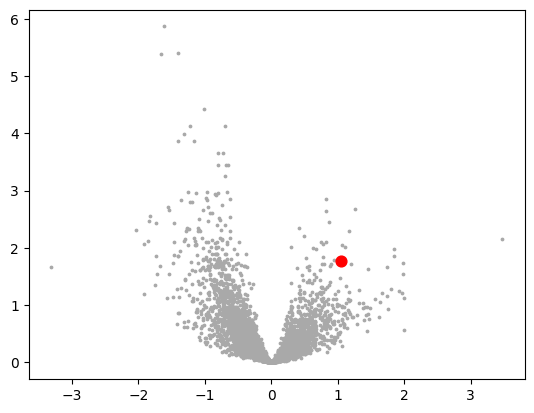

In [65]:
gf=res['baseMean']>5
plt.scatter(res.loc[gf,'log2FoldChange'],-np.log10(res.loc[gf,'padj']),3,'darkgray')
plt.scatter(res.loc["XIST",'log2FoldChange'],-np.log10(res.loc['XIST','padj']),60,'r')

## Linna-Kuosmanen

In [66]:
ad=build_consensus_ad({'linna_kuosmanen':ads['linna_kuosmanen']},filter_by = 'cell_type')

In [67]:
ad.obs['author_batch_notes'].value_counts()

author_batch_notes
Valve disease       59
IHD                 11
IHD+HF              10
CAD+MI               9
CAD                  5
Valve disease+HF     4
Name: count, dtype: int64

In [68]:
ad = ad[(ad.obs['sex']=='male')]

In [69]:
ad.obs['age'] = ad.obs['age'].astype('float')
ad.obs['logage'] = np.log(ad.obs['age'])

/tmp/ipykernel_4384/838056906.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  ad.obs['age'] = ad.obs['age'].astype('float')


In [70]:
ad.obs['pathology'] = None
ad.obs.loc[ad.obs['author_batch_notes']=='Valve disease','pathology'] = 'Valve disease'
ad.obs.loc[ad.obs['author_batch_notes']!='Valve disease','pathology'] = 'Comorbidities'

In [71]:
dds = DeseqDataSet(
    adata=ad.copy(),
    design_factors=['pathology'],
    refit_cooks=True,
    inference=inference,
    quiet=True)
dds.deseq2()
stat_res_Y_vs_X = DeseqStats(dds, contrast=["pathology", "Comorbidities", "Valve disease"], inference=inference,quiet=True)
stat_res_Y_vs_X.summary()
res = stat_res_Y_vs_X.results_df
df_ensembl = pd.read_csv('/home/ec2-user/platform/anno/gene_details_ensembl_v104.txt',sep='\t').set_index('ensembl_id')
dict_ensembl = dict(df_ensembl[['gene_symbol', 'chromosome_name']].values)
res['chr'] = res.index.map(dict_ensembl)
res.to_csv(dedir+'gg_250821_linna_kuosmanen_comorbidities_p.csv')

Fitting dispersions...
... done in 0.04 seconds.

Fitting MAP dispersions...
... done in 0.07 seconds.

Fitting LFCs...
... done in 0.06 seconds.



Log2 fold change & Wald test p-value: pathology Comorbidities vs Valve disease
               baseMean  log2FoldChange     lfcSE      stat    pvalue  \
feature_name                                                            
A1BG           1.967741       -0.205419  0.284225 -0.722736  0.469842   
A1BG-AS1       0.948575        0.203534  0.320978  0.634106  0.526011   
A1CF           0.002547        0.534810  3.118645  0.171488  0.863840   
A2M           17.737923       -0.299220  0.119219 -2.509838  0.012079   
A2M-AS1        0.809403        0.440448  0.480640  0.916377  0.359469   
...                 ...             ...       ...       ...       ...   
ZYG11A         0.099422        0.807716  0.963807  0.838048  0.402004   
ZYG11B         6.624009       -0.057626  0.121117 -0.475789  0.634225   
ZYX            1.100560        0.021704  0.311395  0.069699  0.944433   
ZZEF1          6.532143        0.349785  0.134643  2.597879  0.009380   
ZZZ3          12.978448        0.080514  0.08

In [72]:
res.loc[['XIST']]

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,chr
feature_name,,,,,,,
XIST,22.0991,0.272466,0.128903,2.113725,0.034539,0.214343,X


In [73]:
dds = DeseqDataSet(
    adata=ad.copy(),
    design_factors=['pathology','age'],
    continuous_factors=['age'],
    refit_cooks=True,
    inference=inference,
    quiet=True)
dds.deseq2()
stat_res_Y_vs_X = DeseqStats(dds, contrast=["pathology", "Comorbidities", "Valve disease"], inference=inference,quiet=True)
stat_res_Y_vs_X.summary()
res = stat_res_Y_vs_X.results_df
df_ensembl = pd.read_csv('/home/ec2-user/platform/anno/gene_details_ensembl_v104.txt',sep='\t').set_index('ensembl_id')
dict_ensembl = dict(df_ensembl[['gene_symbol', 'chromosome_name']].values)
res['chr'] = res.index.map(dict_ensembl)
res.to_csv(dedir+'gg_250821_linna_kuosmanen_comorbidites_pa.csv')

Fitting dispersions...
... done in 0.04 seconds.

Fitting MAP dispersions...
... done in 0.04 seconds.

Fitting LFCs...
... done in 0.04 seconds.



Log2 fold change & Wald test p-value: pathology Comorbidities vs Valve disease
               baseMean  log2FoldChange     lfcSE      stat    pvalue  \
feature_name                                                            
A1BG           1.967741       -0.224143  0.284633 -0.787483  0.430999   
A1BG-AS1       0.948575        0.166442  0.322602  0.515936  0.605899   
A1CF           0.002547        0.533823  3.141391  0.169932  0.865064   
A2M           17.737923       -0.367673  0.114221 -3.218960  0.001287   
A2M-AS1        0.809403        0.334248  0.377214  0.886098  0.375565   
...                 ...             ...       ...       ...       ...   
ZYG11A         0.099422        0.776612  0.733142  1.059292  0.289467   
ZYG11B         6.624009       -0.050744  0.103768 -0.489014  0.624832   
ZYX            1.100560        0.041752  0.298931  0.139673  0.888919   
ZZEF1          6.532143        0.322169  0.118405  2.720908  0.006510   
ZZZ3          12.978448        0.033962  0.07

In [74]:
res.loc[['XIST']]

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,chr
feature_name,,,,,,,
XIST,22.0991,0.252677,0.128825,1.961399,0.049832,0.27653,X


In [75]:
dds = DeseqDataSet(
    adata=ad.copy(),
    design_factors=['pathology','logage'],
    continuous_factors=['logage'],
    refit_cooks=True,
    inference=inference,
    quiet=True)
dds.deseq2()
stat_res_Y_vs_X = DeseqStats(dds, contrast=["pathology", "Comorbidities", "Valve disease"], inference=inference,quiet=True)
stat_res_Y_vs_X.summary()
res = stat_res_Y_vs_X.results_df
df_ensembl = pd.read_csv('/home/ec2-user/platform/anno/gene_details_ensembl_v104.txt',sep='\t').set_index('ensembl_id')
dict_ensembl = dict(df_ensembl[['gene_symbol', 'chromosome_name']].values)
res['chr'] = res.index.map(dict_ensembl)
res.to_csv(dedir+'gg_250821_linna_kuosmanen_comorbidites_ploga.csv')

Fitting dispersions...
... done in 0.05 seconds.

Fitting MAP dispersions...
... done in 0.05 seconds.

Fitting LFCs...
... done in 0.05 seconds.



Log2 fold change & Wald test p-value: pathology Comorbidities vs Valve disease
               baseMean  log2FoldChange     lfcSE      stat    pvalue  \
feature_name                                                            
A1BG           1.967741       -0.224403  0.284374 -0.789113  0.430046   
A1BG-AS1       0.948575        0.163316  0.322108  0.507022  0.612139   
A1CF           0.002547        0.535333  3.138634  0.170562  0.864568   
A2M           17.737923       -0.366025  0.114040 -3.209609  0.001329   
A2M-AS1        0.809403        0.337270  0.377171  0.894212  0.371209   
...                 ...             ...       ...       ...       ...   
ZYG11A         0.099422        0.782207  0.776807  1.006951  0.313958   
ZYG11B         6.624009       -0.051217  0.103430 -0.495188  0.620468   
ZYX            1.100560        0.042568  0.298761  0.142481  0.886700   
ZZEF1          6.532143        0.321207  0.118097  2.719852  0.006531   
ZZZ3          12.978448        0.037741  0.07

In [76]:
res.loc[['XIST']]

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,chr
feature_name,,,,,,,
XIST,22.0991,0.251841,0.128717,1.956546,0.050401,0.22598,X


## Kuppe

In [77]:
ad=build_consensus_ad({'kuppe':ads['kuppe']},filter_by = 'cell_type')

In [78]:
ad = ad[(ad.obs['sex']=='male')]

In [79]:
ad.obs['disease'].value_counts()

disease
myocardial infarction    12
normal                    3
Name: count, dtype: int64

In [80]:
ad.obs['age'] = ad.obs['age'].astype('float')
ad.obs['logage'] = np.log(ad.obs['age'])

/tmp/ipykernel_4384/838056906.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  ad.obs['age'] = ad.obs['age'].astype('float')


In [81]:
dds = DeseqDataSet(
    adata=ad.copy(),
    design_factors=['disease'],
    refit_cooks=True,
    inference=inference,
    quiet=True)
dds.deseq2()
stat_res_Y_vs_X = DeseqStats(dds, contrast=["disease", "myocardial infarction", "normal"], inference=inference,quiet=True)
stat_res_Y_vs_X.summary()
res = stat_res_Y_vs_X.results_df
df_ensembl = pd.read_csv('/home/ec2-user/platform/anno/gene_details_ensembl_v104.txt',sep='\t').set_index('ensembl_id')
dict_ensembl = dict(df_ensembl[['gene_symbol', 'chromosome_name']].values)
res['chr'] = res.index.map(dict_ensembl)
res.to_csv(dedir+'gg_250821_kuppe_mci_p.csv')

Fitting dispersions...
... done in 0.02 seconds.

Fitting MAP dispersions...
... done in 0.02 seconds.

Fitting LFCs...
... done in 0.03 seconds.



Log2 fold change & Wald test p-value: disease myocardial infarction vs normal
               baseMean  log2FoldChange     lfcSE      stat    pvalue  \
feature_name                                                            
A1BG           1.078819       -0.580889  0.829086 -0.700637  0.483529   
A1BG-AS1       2.298696       -0.020476  0.749313 -0.027327  0.978199   
A1CF           0.000000             NaN       NaN       NaN       NaN   
A2M           17.202850       -0.695214  0.499682 -1.391311  0.164131   
A2M-AS1        0.354763       -2.357394  1.857863 -1.268874  0.204486   
...                 ...             ...       ...       ...       ...   
ZYG11A         0.714083        2.631685  3.978505  0.661476  0.508307   
ZYG11B        12.921485        0.238563  0.247382  0.964347  0.334872   
ZYX            2.140168        1.057983  0.691948  1.528993  0.126266   
ZZEF1         19.769932        0.053894  0.241909  0.222785  0.823703   
ZZZ3          21.630684       -0.142125  0.248

In [82]:
res.loc[['XIST']]

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,chr
feature_name,,,,,,,
XIST,20.142269,-0.551471,0.928959,-0.593644,0.55275,0.999655,X


In [83]:
dds = DeseqDataSet(
    adata=ad.copy(),
    design_factors=['disease','age'],
    continuous_factors=['age'],
    refit_cooks=True,
    inference=inference,
    quiet=True)
dds.deseq2()
stat_res_Y_vs_X = DeseqStats(dds, contrast=["disease", "myocardial infarction", "normal"], inference=inference,quiet=True)
stat_res_Y_vs_X.summary()
res = stat_res_Y_vs_X.results_df
df_ensembl = pd.read_csv('/home/ec2-user/platform/anno/gene_details_ensembl_v104.txt',sep='\t').set_index('ensembl_id')
dict_ensembl = dict(df_ensembl[['gene_symbol', 'chromosome_name']].values)
res['chr'] = res.index.map(dict_ensembl)
res.to_csv(dedir+'gg_250821_kuppe_mci_pa.csv')

Log2 fold change & Wald test p-value: disease myocardial infarction vs normal
               baseMean  log2FoldChange     lfcSE      stat    pvalue  \
feature_name                                                            
A1BG           1.078819       -0.729256  0.812013 -0.898085  0.369140   
A1BG-AS1       2.298696        0.019044  0.772359  0.024657  0.980329   
A1CF           0.000000             NaN       NaN       NaN       NaN   
A2M           17.202850       -0.696143  0.519347 -1.340420  0.180109   
A2M-AS1        0.354763       -2.346818  1.860517 -1.261380  0.207172   
...                 ...             ...       ...       ...       ...   
ZYG11A         0.714083        2.323022  4.154341  0.559179  0.576039   
ZYG11B        12.921485        0.271427  0.210662  1.288447  0.197590   
ZYX            2.140168        0.928155  0.782112  1.186729  0.235335   
ZZEF1         19.769932        0.042243  0.241083  0.175224  0.860904   
ZZZ3          21.630684       -0.077480  0.135

In [84]:
res.loc[['XIST']]

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,chr
feature_name,,,,,,,
XIST,20.142269,-0.70845,0.992636,-0.713706,0.475409,0.999528,X


In [85]:
dds = DeseqDataSet(
    adata=ad.copy(),
    design_factors=['disease','logage'],
    continuous_factors=['logage'],
    refit_cooks=True,
    inference=inference,
    quiet=True)
dds.deseq2()
stat_res_Y_vs_X = DeseqStats(dds, contrast=["disease", "myocardial infarction", "normal"], inference=inference,quiet=True)
stat_res_Y_vs_X.summary()
res = stat_res_Y_vs_X.results_df
df_ensembl = pd.read_csv('/home/ec2-user/platform/anno/gene_details_ensembl_v104.txt',sep='\t').set_index('ensembl_id')
dict_ensembl = dict(df_ensembl[['gene_symbol', 'chromosome_name']].values)
res['chr'] = res.index.map(dict_ensembl)
res.to_csv(dedir+'gg_250821_kuppe_mci_ploga.csv')

Log2 fold change & Wald test p-value: disease myocardial infarction vs normal
               baseMean  log2FoldChange     lfcSE      stat    pvalue  \
feature_name                                                            
A1BG           1.078819       -0.565075  0.560104 -1.008875  0.313035   
A1BG-AS1       2.298696        0.032755  0.711192  0.046057  0.963265   
A1CF           0.000000             NaN       NaN       NaN       NaN   
A2M           17.202850       -0.696868  0.518044 -1.345190  0.178564   
A2M-AS1        0.354763       -2.339443  1.856637 -1.260043  0.207654   
...                 ...             ...       ...       ...       ...   
ZYG11A         0.714083        2.362585  4.151001  0.569160  0.569247   
ZYG11B        12.921485        0.270778  0.283834  0.954000  0.340084   
ZYX            2.140168        0.925388  0.777089  1.190840  0.233716   
ZZEF1         19.769932        0.049814  0.241703  0.206097  0.836715   
ZZZ3          21.630684       -0.077545  0.135

In [86]:
res.loc[['XIST']]

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,chr
feature_name,,,,,,,
XIST,20.142269,-0.679804,0.994456,-0.683595,0.494231,0.999743,X


## Simonson

In [87]:
ad=build_consensus_ad({'simonson':ads['simonson']},filter_by = 'cell_type')

In [88]:
ad = ad[(ad.obs['sex']=='male')]

In [89]:
ad.obs['disease'].value_counts()

disease
NF     4
ICM    3
Name: count, dtype: int64

In [90]:
ad.obs['age'] = ad.obs['age'].astype('float')
ad.obs['logage'] = np.log(ad.obs['age'])

/tmp/ipykernel_4384/838056906.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  ad.obs['age'] = ad.obs['age'].astype('float')


In [91]:
dds = DeseqDataSet(
    adata=ad.copy(),
    design_factors=['disease'],
    refit_cooks=True,
    inference=inference,
    quiet=True)
dds.deseq2()
stat_res_Y_vs_X = DeseqStats(dds, contrast=["disease", "ICM", "NF"], inference=inference,quiet=True)
stat_res_Y_vs_X.summary()
res = stat_res_Y_vs_X.results_df
df_ensembl = pd.read_csv('/home/ec2-user/platform/anno/gene_details_ensembl_v104.txt',sep='\t').set_index('ensembl_id')
dict_ensembl = dict(df_ensembl[['gene_symbol', 'chromosome_name']].values)
res['chr'] = res.index.map(dict_ensembl)
res.to_csv(dedir+'gg_250821_simonson_icm_p.csv')

Log2 fold change & Wald test p-value: disease ICM vs NF
          baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG      0.463857        2.332679  2.389347  0.976283  0.328924  0.997939
A1BG-AS1  0.404149        0.373218  2.552206  0.146234  0.883737  0.997939
A2M       4.214934       -0.552545  0.831103 -0.664833  0.506157  0.997939
A2M-AS1   0.000000             NaN       NaN       NaN       NaN       NaN
A2ML1     0.638795        2.955412  2.567211  1.151215  0.249644  0.997939
...            ...             ...       ...       ...       ...       ...
ZXDC      3.362018       -0.779191  0.611904 -1.273388  0.202880  0.997939
ZYG11A    0.000000             NaN       NaN       NaN       NaN       NaN
ZYG11B    2.311872       -0.999850  0.797088 -1.254379  0.209704  0.997939
ZYX       0.817428       -1.300938  1.884466 -0.690348  0.489975  0.997939
ZZEF1     3.889442       -0.343288  0.842318 -0.407551  0.683603  0.997939

[19061 rows x 6 columns]


In [92]:
res.loc[['XIST']]

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,chr
XIST,8.903639,-0.934648,0.611623,-1.528144,0.126477,0.997939,X


In [93]:
dds = DeseqDataSet(
    adata=ad.copy(),
    design_factors=['disease','age'],
    continuous_factors=['age'],
    refit_cooks=True,
    inference=inference,
    quiet=True)
dds.deseq2()
stat_res_Y_vs_X = DeseqStats(dds, contrast=["disease", "ICM", "NF"], inference=inference,quiet=True)
stat_res_Y_vs_X.summary()
res = stat_res_Y_vs_X.results_df
df_ensembl = pd.read_csv('/home/ec2-user/platform/anno/gene_details_ensembl_v104.txt',sep='\t').set_index('ensembl_id')
dict_ensembl = dict(df_ensembl[['gene_symbol', 'chromosome_name']].values)
res['chr'] = res.index.map(dict_ensembl)
res.to_csv(dedir+'gg_250821_simonson_icm_pa.csv')

/home/ec2-user/miniconda/lib/python3.9/site-packages/pydeseq2/utils.py:549: RuntimeWarning: overflow encountered in exp
  mu_ = np.maximum(size_factors * np.exp(X @ beta), min_mu)
/home/ec2-user/miniconda/lib/python3.9/site-packages/pydeseq2/utils.py:404: RuntimeWarning: invalid value encountered in multiply
  - counts * np.log(mu)
/home/ec2-user/miniconda/lib/python3.9/site-packages/pydeseq2/utils.py:402: RuntimeWarning: invalid value encountered in subtract
  -logbinom
/home/ec2-user/miniconda/lib/python3.9/site-packages/pydeseq2/utils.py:553: RuntimeWarning: overflow encountered in exp
  mu_ = np.maximum(size_factors * np.exp(X @ beta), min_mu)
/home/ec2-user/miniconda/lib/python3.9/site-packages/pydeseq2/utils.py:556: RuntimeWarning: invalid value encountered in divide
  + ((1 / disp + counts) * mu_ / (1 / disp + mu_)) @ X
/home/ec2-user/miniconda/lib/python3.9/site-packages/pydeseq2/utils.py:549: RuntimeWarning: overflow encountered in exp
  mu_ = np.maximum(size_factors * np.exp(

Log2 fold change & Wald test p-value: disease ICM vs NF
          baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG      0.463857        2.081524  2.793321  0.745179  0.456163  0.999219
A1BG-AS1  0.404149        0.017348  2.957588  0.005866  0.995320  0.999400
A2M       4.214934       -0.178458  0.963408 -0.185236  0.853044  0.999219
A2M-AS1   0.000000             NaN       NaN       NaN       NaN       NaN
A2ML1     0.638795        2.518513  2.882650  0.873680  0.382293  0.999219
...            ...             ...       ...       ...       ...       ...
ZXDC      3.362018       -0.774875  0.650887 -1.190492  0.233853  0.999219
ZYG11A    0.000000             NaN       NaN       NaN       NaN       NaN
ZYG11B    2.311872       -1.189900  1.285665 -0.925514  0.354699  0.999219
ZYX       0.817428       -1.584132  2.119517 -0.747402  0.454821  0.999219
ZZEF1     3.889442       -0.401252  0.975467 -0.411344  0.680821  0.999219

[19061 rows x 6 columns]


In [94]:
res.loc[['XIST']]

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,chr
XIST,8.903639,-0.953018,0.712657,-1.337275,0.181133,0.999219,X


In [95]:
dds = DeseqDataSet(
    adata=ad.copy(),
    design_factors=['disease','logage'],
    continuous_factors=['logage'],
    refit_cooks=True,
    inference=inference,
    quiet=True)
dds.deseq2()
stat_res_Y_vs_X = DeseqStats(dds, contrast=["disease", "ICM", "NF"], inference=inference,quiet=True)
stat_res_Y_vs_X.summary()
res = stat_res_Y_vs_X.results_df
df_ensembl = pd.read_csv('/home/ec2-user/platform/anno/gene_details_ensembl_v104.txt',sep='\t').set_index('ensembl_id')
dict_ensembl = dict(df_ensembl[['gene_symbol', 'chromosome_name']].values)
res['chr'] = res.index.map(dict_ensembl)
res.to_csv(dedir+'gg_250821_simonson_icm_ploga.csv')

Log2 fold change & Wald test p-value: disease ICM vs NF
          baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG      0.463857        2.033313  2.850688  0.713271  0.475678  0.999735
A1BG-AS1  0.404149       -0.038069  3.020108 -0.012605  0.989943  0.999735
A2M       4.214934       -0.198817  0.980997 -0.202669  0.839394  0.999735
A2M-AS1   0.000000             NaN       NaN       NaN       NaN       NaN
A2ML1     0.638795        2.586653  2.953190  0.875885  0.381093  0.999735
...            ...             ...       ...       ...       ...       ...
ZXDC      3.362018       -0.768453  1.089101 -0.705584  0.480447  0.999735
ZYG11A    0.000000             NaN       NaN       NaN       NaN       NaN
ZYG11B    2.311872       -1.201079  1.308548 -0.917871  0.358686  0.999735
ZYX       0.817428       -1.559338  2.156122 -0.723214  0.469548  0.999735
ZZEF1     3.889442       -0.427267  0.991887 -0.430762  0.666641  0.999735

[19061 rows x 6 columns]


In [96]:
res.loc[['XIST']]

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,chr
XIST,8.903639,-0.95715,0.720656,-1.328165,0.184123,0.999735,X
